In [1]:
# Librerías
import pandas as pd
import numpy as np
from pathlib import Path
import os

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

In [2]:
sns.set_theme(style="darkgrid")

In [3]:
# Variables
src_path = os.getcwd()
data_path = "/data/raw/"
data_file = "merged_data.csv"

file_path= Path(os.path.dirname(src_path)+data_path+data_file)

In [4]:
df_coffee = pd.read_csv(file_path)

In [5]:
df_coffee.shape

(1339, 44)

In [6]:
df_coffee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             1339 non-null   int64  
 1   Species                1339 non-null   object 
 2   Owner                  1332 non-null   object 
 3   Country.of.Origin      1338 non-null   object 
 4   Farm.Name              980 non-null    object 
 5   Lot.Number             276 non-null    object 
 6   Mill                   1021 non-null   object 
 7   ICO.Number             1180 non-null   object 
 8   Company                1130 non-null   object 
 9   Altitude               1113 non-null   object 
 10  Region                 1280 non-null   object 
 11  Producer               1107 non-null   object 
 12  Number.of.Bags         1339 non-null   int64  
 13  Bag.Weight             1339 non-null   object 
 14  In.Country.Partner     1339 non-null   object 
 15  Harv

<h2 style="text-align: center;">ANALIZANDO EL DATASET</h2>

El dataset consta de 1339 filas por 44 columnas y contiene la información relativa a diferentes variedades de café de tipo Arabica y Robusta calificadas por personal del CQI (Coffee Quality Institute).

La información se divide en:

Calidad de café (Cupping Score)
- Aroma
- Flavor
- Aftertaste
- Acidity
- Body
- Balance
- Uniformity
- Clean Cup
- Sweetness


Semilla (Bean)
- Species (arabica / robusta)
- Variety
- Processing Method
- Moisture
- Color
- Category.One.Defects
- Category.Two.Defects
- Quakers
- Expiration


Plantación (Farm)
- Country.of.Origin
- Harvest.Year
- Farm.Name
- Mill
- Owner
- Company
- Altitude + unit_of_measurement
- Region



La columna "Total Cup Points" será nuestro medidor de calidad, siendo mejor el café cuanto más alta sea esta puntuación.

Realizaremos un análisis univariante y multivariante de las información de la calidad y de la semilla junto con el país de origen, región, año de cosecha y altitud de la plantación con el objetivo final de encontrar un algoritmo que permita predecir qué café tendrá una mejor puntuación en función de todas sus características.

Para la información de la altitud, nos quedaremos con la columna "Altitude" y "altitude_mean_meters" que representa la media entre el valor máximo y mínimo de la altitud a la que se cultiva esa variedad de café en esa plantación. Además, necesitamos la columna "unit_of_measurement" para saber si la medida está en metros o pies.

<h2 style="text-align: center;">LIMPIEZA DEL DATASET</h2>

Borramos las columnas que no nos serán necesarias para la realización del análisis.

In [7]:
df = df_coffee.drop(columns=["Unnamed: 0", "Lot.Number", "ICO.Number", "Producer", "Number.of.Bags",
                             "Bag.Weight", "In.Country.Partner", "Grading.Date", "Cupper.Points",
                             "Certification.Body", "Certification.Address", "Certification.Contact",
                             "altitude_low_meters", "altitude_high_meters", "Owner.1", "Farm.Name",
                             "Mill", "Company", "Owner"])

<h3 style="text-align: center;">Chequeo de duplicados</h3>

In [8]:
# Cantidad de duplicados
df.duplicated().sum()

0

No hay registros duplicados.

<h3 style="text-align: center;">Chequeo de valores nulos</h3>

In [9]:
# Null / Missing values
df[df.columns[df.isnull().any()]].isnull().sum().sort_values(ascending=False)

Color                   270
altitude_mean_meters    230
Altitude                226
Variety                 226
Processing.Method       170
Region                   59
Harvest.Year             47
Country.of.Origin         1
Quakers                   1
dtype: int64

Hay bastante cantidad de valores nulos. Vamos a tratar de reducirlos todo lo posible.

<h4 style="text-align: center;"><ins>1 - Nulos en Region</ins></h4>

Saber la región en la que se cultiva un café puede ser importante para sus características.

Comprobamos si podemos inferir a qué región pertenece un café en función de su país de origen y la altitud media a la que se encuentra la plantación. La idea es que si uno de los registros nulos comparte altura y pais de origen con otro que que tenga un valor, supondremos que se trata de la misma región.

In [10]:
df.loc[(df["Region"].isnull()) & (df["Country.of.Origin"].notnull()), ["Country.of.Origin", "Region", 'altitude_mean_meters']]

,Country.of.Origin,Region,altitude_mean_meters
2,Guatemala,NaN,1700.0
5,Brazil,NaN,NaN
6,Peru,NaN,NaN
30,Nicaragua,NaN,NaN
31,"Tanzania, United Republic Of",NaN,NaN
100,Kenya,NaN,1.0
114,Kenya,NaN,NaN
134,Costa Rica,NaN,NaN
152,Kenya,NaN,NaN
223,Guatemala,NaN,NaN


La práctica totalidad de los registros con valor nulo en el campo de Región también presenta valor nulo para su altura media, con lo que es imposible imputar valores y por tanto decidimos eliminar estos registros.

In [11]:
df = df[df["Region"].notna()]

<h4 style="text-align: center;"><ins>2 - Nulos en altitud</ins></h4>


Uno de los valores que hemos considerado importante en el análisis es la altitud a la que se cultiva el café, por lo que es el primer dato que vamos a analizar 

1 - Comprobamos los valores de la columna "Altitud" que no son nulos junto con los de altitud media para tratar de imputar algún valor a esta última columna.

In [12]:
df.loc[(df["altitude_mean_meters"].isnull()) & df["Altitude"].notnull(), ["Altitude", "altitude_mean_meters"]]

,Altitude,altitude_mean_meters
169,mmm,NaN
170,test,NaN
687,huanuco,NaN
986,0,NaN


Con esos valores no podemos realizar ningún cálculo.

Antes de realizar las imputaciones debemos tener en cuenta la unidad de medida en que está la columna de altitud y asegurarnos que todos los valores están en metros.

In [13]:
df["altitude_recalc"] = df.apply(lambda x: x["altitude_mean_meters"] if x["unit_of_measurement"]=='m' else x["altitude_mean_meters"]*0.3048, axis=1)

Estudiamos los valores estadísticos de la columna, pues si vamos a realizar imputaciones a la media o a la moda debemos asegurarnos de que no existan valores fuera de rango que nos provoquen errores.

In [14]:
df["altitude_recalc"].describe()

count      1105.000000
mean       1688.238037
std        8692.930061
min           1.000000
25%         950.000000
50%        1300.000000
75%        1600.000000
max      190164.000000
Name: altitude_recalc, dtype: float64

Se observa un valor máximo demasiado elevado y un mínimo demasiado bajo, así como una desviación estándar alta. Cualquier valor por encima de los 3000m y por debajo de los 600m lo consideraremos un error y usaremos esos valores como extremos.

In [15]:
df.loc[df["altitude_recalc"]>3000, "altitude_recalc"] = 3000
df.loc[df["altitude_recalc"]<600, "altitude_recalc"] = 600

In [16]:
df["altitude_recalc"].describe()

count    1105.000000
mean     1280.425339
std       469.677888
min       600.000000
25%       950.000000
50%      1300.000000
75%      1600.000000
max      3000.000000
Name: altitude_recalc, dtype: float64

Con unos valores más ajustados a la realidad, podemos pasar a tratar los valores nulos

2 - Imputaremos los valores de altitud correspondientes a la media de la región a la que pertenecen.

In [17]:
df["altitude_recalc"].fillna(df.groupby(["Region"])["altitude_recalc"].transform("mean"), inplace=True)
print("Quedan {} valores nulos en la columna.". format(df["altitude_recalc"].isnull().sum()))

Quedan 22 valores nulos en la columna.


3 - Dado que aún quedan valores nulos, vamos a repetir el proceso pero imputando la moda de la altura con respecto al país. Decidimos no usar la media porque puede ocurrir que en un mismo país haya grandes diferencias en la altura en que sitúan las plantaciones.

In [18]:
df["altitude_recalc"].fillna(df.groupby(['Country.of.Origin'])['altitude_recalc'].transform(lambda x: x.mode()[0]), inplace=True)
print("Quedan {} valores nulos en la columna.". format(df["altitude_recalc"].isnull().sum()))

Quedan 0 valores nulos en la columna.


Hemos quitado todos los valores nulos de la altitud media, por lo que la columna Altitude se hace innecesaria en el conjunto de datos y procedemos a eliminarla.

In [19]:
df = df.drop(columns=["Altitude"])

<h4 style="text-align: center;"><ins>3 - Nulos en variedad</ins></h4>

Antes de estudiar los registros nulos comprobamos los diferentes tipos de variedad que hay en la tabla

In [20]:
df["Variety"].unique()

array([nan, 'Other', 'Catimor', 'Ethiopian Yirgacheffe', 'Caturra',
       'Bourbon', 'SL14', 'Sumatra', 'SL34', 'Hawaiian Kona',
       'Yellow Bourbon', 'SL28', 'Gesha', 'Catuai', 'Pacamara', 'Typica',
       'Sumatra Lintong', 'Mundo Novo', 'Java', 'Peaberry', 'Pacas',
       'Mandheling', 'Ruiru 11', 'Ethiopian Heirlooms', 'Moka Peaberry',
       'Arusha', 'Sulawesi', 'Blue Mountain', 'Marigojipe', 'Pache Comun'],
      dtype=object)

Dado que ya existe un valor genérico establecido como "Other" decidimos imputarles a todos los nulos ese valor genérico.

In [21]:
df["Variety"].fillna("Other", inplace = True)
print("Quedan {} valores nulos en la columna.". format(df["Variety"].isnull().sum()))

Quedan 0 valores nulos en la columna.


<h4 style="text-align: center;"><ins>4 - Nulos en Color</ins></h3>

Antes de estudiar los valores nulos, comprobamos los diferentes colores presentes en el dataset

In [22]:
df["Color"].unique()

array(['Green', nan, 'Bluish-Green', 'Blue-Green'], dtype=object)

El color de las semillas de café, antes del tostado, suele depender de la región en la que se hayan cultivado, pero habitualmente son de color verde por lo que imputaremos a los valores nulos el color verde.

In [23]:
df["Color"].fillna("Green", inplace=True)
print("Quedan {} valores nulos en la columna.". format(df["Color"].isnull().sum()))

Quedan 0 valores nulos en la columna.


<h4 style="text-align: center;"><ins>5 - Nulos en Método de procesado</ins></h3>

Como anteriormente, vamos a comprobar los tipos de métodos de procesado existentes en el dataframe.

In [24]:
df["Processing.Method"].unique()

array(['Washed / Wet', 'Natural / Dry', nan, 'Pulped natural / honey',
       'Semi-washed / Semi-pulped', 'Other'], dtype=object)

Dado que el método de procesado es difícil de imputar pues no tiene por qué seguir una lógica en función de la región o el país, vamos a imputar a todos los nulos el valor genérico "Other" que ya existe.

In [25]:
df["Processing.Method"].fillna("Other", inplace=True)
print("Quedan {} valores nulos en la columna.". format(df["Processing.Method"].isnull().sum()))

Quedan 0 valores nulos en la columna.


<h4 style="text-align: center;"><ins>6 - Nulos en Año de cosecha</ins></h3>

In [26]:
df["Harvest.Year"].unique()

array(['2014', 'March 2010', 'Sept 2009 - April 2010', 'May-August',
       '2009/2010', '2015', '2012', '2013', '2011', '2016', '2015/2016',
       '2010', 'Fall 2009', '2017', '2009 / 2010', '2010-2011', nan,
       '2009 - 2010', '2013/2014', '2017 / 2018', 'mmm', 'TEST',
       'December 2009-March 2010', '2014/2015', '2011/2012',
       'January 2011', '4T/10', '23 July 2010', 'January Through April',
       '1T/2011', '4t/2010', '4T/2010', 'August to December',
       'Mayo a Julio', '47/2010', 'Abril - Julio', '4t/2011', '2009-2010',
       'Abril - Julio /2011', 'Spring 2011 in Colombia.', '2016 / 2017',
       '3T/2011', '1t/2011', '2018', '4T72010', '08/09 crop'],
      dtype=object)

Viendo la cantidad de variabilidad que hay en la columna, decidimos extraer la última aparición de una cifra de 4 dígitos y tomarlos como el año de la cosecha. Almacenaremos el resultado en una nueva columna.

In [27]:
df["HarvestYear_Calc"] = df["Harvest.Year"].str.extract('(\d{4})(?!.*\d)')

Examinamos de nuevo los valores obtenidos tras la imputación.

In [28]:
df["HarvestYear_Calc"].unique()

array(['2014', '2010', nan, '2015', '2012', '2013', '2011', '2016',
       '2009', '2017', '2018'], dtype=object)

Nos quedan valores nulos, a los que imputaremos el valor genérico "unknown", pues para tratarlos deberíamos ir uno por uno.

In [29]:
df["HarvestYear_Calc"].fillna("UNKNOWN", inplace=True)
print("Quedan {} valores nulos en la columna.". format(df["HarvestYear_Calc"].isnull().sum()))

Quedan 0 valores nulos en la columna.


Ya no es necesaria la columna original del año de cosecha, por lo que podemos eliminarla

In [30]:
df.drop(columns=["Harvest.Year"], inplace=True)

<h4 style="text-align: center;"><ins>7 - Nulos en Quakers</ins></h3>

Los "Quakers" son aquéllas semillas de café que, por no estar maduras y por tanto no tener suficientes azúcares, no se caramelizan con el tostado y si no se retiran pueden provocar un empeoramiento de la calidad del café.

Esta columna indica el número de estas semillas encontradas en el saco de café.

In [31]:
df[df["Quakers"].isnull()]

,Species,Country.of.Origin,Region,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,...,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,Expiration,unit_of_measurement,altitude_mean_meters,altitude_recalc,HarvestYear_Calc
366,Arabica,Colombia,huila,Caturra,Washed / Wet,7.58,7.67,7.58,7.75,7.58,...,0.11,0,NaN,Green,2,"May 24th, 2014",m,1750.0,1750.0,2013


Como sólo tenemos un caso con un valor nulo y no podemos imputar ningún valor pues es una característica independiente a la región o al país, lo eliminaremos sin que afecte al desarrollo del análisis.

In [32]:
df = df[df["Quakers"].notna()]

---

<h2 style="text-align: center;">ANÁLISIS DE LOS DATOS</h2>

<h4 style="text-align: center;"><ins>1 - País de Origen</ins></h4>

Examinamos los valores únicos de la columna, por si fuera necesario realizar alguna codificación o traducción en sus valores.

In [33]:
df["Country.of.Origin"].unique()

array(['Ethiopia', 'United States', 'United States (Hawaii)', 'Indonesia',
       'China', 'Costa Rica', 'Mexico', 'Brazil', 'Uganda', 'Honduras',
       'Taiwan', 'Kenya', 'Thailand', 'Colombia', 'Guatemala', 'Panama',
       'Peru', 'Papua New Guinea', 'El Salvador',
       'Tanzania, United Republic Of', 'Nicaragua', 'Japan', 'Ecuador',
       'United States (Puerto Rico)', 'Haiti', 'Burundi', 'Vietnam',
       'Philippines', 'Rwanda', 'Malawi', 'Laos', 'Zambia', 'Myanmar',
       'Mauritius', 'Cote d?Ivoire', 'India'], dtype=object)

Los valores son relativamente pocos y no es necesario realizar ningún cambio.

<h4 style="text-align: center;"><ins>2 - Especie</ins></h4>

Examinanos las especies presentes en el dataset.

In [34]:
df["Species"].unique()

array(['Arabica', 'Robusta'], dtype=object)

Solamente hay dos especies y ningún registro carece de esta información.

<h4 style="text-align: center;"><ins>3 - Variedad</ins></h4>

Examinamos los tipos de variedad presentes en el conjunto de datos.

In [35]:
df["Variety"].unique()

array(['Other', 'Catimor', 'Ethiopian Yirgacheffe', 'Caturra', 'Bourbon',
       'SL14', 'Sumatra', 'SL34', 'Hawaiian Kona', 'Yellow Bourbon',
       'SL28', 'Gesha', 'Catuai', 'Pacamara', 'Typica', 'Sumatra Lintong',
       'Mundo Novo', 'Java', 'Peaberry', 'Pacas', 'Mandheling',
       'Ruiru 11', 'Ethiopian Heirlooms', 'Moka Peaberry', 'Arusha',
       'Sulawesi', 'Blue Mountain', 'Marigojipe', 'Pache Comun'],
      dtype=object)

Aunque son bastantes, no existe ningún valor extraño y todo aquéllo que no está definido tiene el valor genérico "Other"

<h4 style="text-align: center;"><ins>4 - Altitud</ins></h4>

Analizamos los valores de la columna relativa a la altitud media del cultivo. Dado que es un valor numérico, además del número de valores que presenta realizaremos un análisis de sus valores estadísticos.

In [36]:
df["altitude_recalc"].describe()

count    1279.000000
mean     1243.125754
std       472.959052
min       600.000000
25%       850.000000
50%      1250.000000
75%      1570.191489
max      3000.000000
Name: altitude_recalc, dtype: float64

Tener tanta variedad de alturas va a suponer un problema a la hora de analizar los datos y en el momento de las predicciones, por lo que se hace necesario realizar agrupamientos de valores a fin de simplificar esta categoría.

In [37]:
df["altitude_groups"] = ["Below 1000m" if x<=1000 else ("Between 1000 and 2000m" if x>1000 and x<=2000 else "Above 2000m") for x in df["altitude_recalc"]]

<h4 style="text-align: center;"><ins>5 - Método de procesado</ins></h4>

Examinamos los valores existentes para el método de procesado.

In [38]:
df["Processing.Method"].unique()

array(['Washed / Wet', 'Natural / Dry', 'Other', 'Pulped natural / honey',
       'Semi-washed / Semi-pulped'], dtype=object)

Todos los valores son correctos y existe un valor genérico.

<h4 style="text-align: center;"><ins>6 - Color</ins></h4>

Como en los casos anteriores, examinamos los valores del color que puede presentar la semilla del café.

In [39]:
df["Color"].unique()

array(['Green', 'Bluish-Green', 'Blue-Green'], dtype=object)

Al haber tratado con anterioridad los nulos, no es necesario realizar ninguna modificación adicional.

<h4 style="text-align: center;"><ins>7 - Quakers</ins></h4>

Listamos los valores que toma la columna "quakers"

In [40]:
df["Quakers"].unique()

array([ 0.,  1.,  4.,  2.,  6.,  3., 11.,  7.,  5.,  9.,  8.])

Examinaremos la cantidad de cada uno de los valores, por si fuera útil realizar agrupamientos.

In [41]:
df["Quakers"].value_counts()

Quakers
0.0     1188
1.0       38
2.0       29
4.0        5
3.0        5
6.0        4
5.0        4
7.0        3
11.0       1
9.0        1
8.0        1
Name: count, dtype: int64

Ante esos valores, decidimos realizar una división en 3 grupos.

In [42]:
df["quakers_groups"] = [str(x) if x>=0 and x<=2 else ("Between 3 and 5" if x>=3 and x<=5 else "More than 5") for x in df["Quakers"]]

<h4 style="text-align: center;"><ins>8 - Año de cosecha</ins></h4>

In [43]:
df["HarvestYear_Calc"].unique()

array(['2014', '2010', 'UNKNOWN', '2015', '2012', '2013', '2011', '2016',
       '2009', '2017', '2018'], dtype=object)

In [44]:
df["HarvestYear_Calc"].value_counts()

HarvestYear_Calc
2012       341
2014       259
2013       169
2016       152
2015       146
2017        73
UNKNOWN     45
2010        37
2011        36
2018        20
2009         1
Name: count, dtype: int64

<h4 style="text-align: center;"><ins>9 - Variedad</ins></h4>

In [45]:
df["Variety"].unique()

array(['Other', 'Catimor', 'Ethiopian Yirgacheffe', 'Caturra', 'Bourbon',
       'SL14', 'Sumatra', 'SL34', 'Hawaiian Kona', 'Yellow Bourbon',
       'SL28', 'Gesha', 'Catuai', 'Pacamara', 'Typica', 'Sumatra Lintong',
       'Mundo Novo', 'Java', 'Peaberry', 'Pacas', 'Mandheling',
       'Ruiru 11', 'Ethiopian Heirlooms', 'Moka Peaberry', 'Arusha',
       'Sulawesi', 'Blue Mountain', 'Marigojipe', 'Pache Comun'],
      dtype=object)

<h4 style="text-align: center;"><ins>10 - Aroma</ins></h4>

In [46]:
df["Aroma"].unique()

array([8.67, 8.75, 8.17, 8.25, 8.08, 8.33, 8.  , 8.42, 8.5 , 7.83, 7.92,
       7.67, 7.75, 7.58, 7.5 , 7.42, 7.81, 7.33, 7.25, 7.17, 7.08, 5.08,
       6.92, 7.  , 6.83, 6.75, 6.67, 6.42, 6.17, 6.5 , 6.33, 0.  ])

In [47]:
df["Aroma"].describe()

count    1279.000000
mean        7.566239
std         0.377272
min         0.000000
25%         7.420000
50%         7.580000
75%         7.750000
max         8.750000
Name: Aroma, dtype: float64

Los valores estadísticos de la puntuación de Aroma están dentro de los valores esperados, pero resulta difícil creer que exista una puntuación 0 para un valor, por lo que puede ser un error y debemos estudiarlo.

In [48]:
df.loc[df["Aroma"]==0]

,Species,Country.of.Origin,Region,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,...,Quakers,Color,Category.Two.Defects,Expiration,unit_of_measurement,altitude_mean_meters,altitude_recalc,HarvestYear_Calc,altitude_groups,quakers_groups
1310,Arabica,Honduras,comayagua,Caturra,Other,0.0,0.0,0.0,0.0,0.0,...,0.0,Green,2,"April 28th, 2018",m,1400.0,1400.0,2017,Between 1000 and 2000m,0.0


Puede observarse que tiene todos sus valores de calidad a 0 por lo que entendemos que es un error, ya sea porque esta variedad no se analizó o porque los registros de las puntuaciones no han sido almacenados.

En cualquier caso, vamos a eliminarlo pues no es de ninguna utilidad.

In [49]:
df = df[df["Aroma"]>0]

<h4 style="text-align: center;"><ins>11 - Sabor</ins></h4>

In [50]:
df["Flavor"].unique()

array([8.83, 8.67, 8.58, 8.5 , 8.33, 8.42, 8.25, 8.17, 8.08, 8.  , 7.83,
       7.75, 7.92, 7.58, 7.67, 7.81, 7.5 , 7.88, 7.42, 7.33, 7.25, 7.  ,
       7.08, 7.17, 6.92, 6.67, 6.83, 6.5 , 6.75, 6.08, 6.17, 6.33, 6.58,
       6.42])

In [51]:
df["Flavor"].describe()

count    1278.000000
mean        7.524867
std         0.338562
min         6.080000
25%         7.330000
50%         7.580000
75%         7.750000
max         8.830000
Name: Flavor, dtype: float64

Todos los valores estadísticos para la variable Flavor están dentro de los esperados y no parece haber ninguno fuera de rango.

<h4 style="text-align: center;"><ins>12 - Regusto</ins></h4>

In [52]:
df["Aftertaste"].unique()

array([8.67, 8.5 , 8.42, 8.25, 8.58, 8.17, 8.33, 8.08, 7.83, 8.  , 7.92,
       7.75, 7.67, 7.58, 7.42, 7.5 , 7.88, 7.33, 7.56, 7.25, 7.38, 7.17,
       7.08, 7.  , 6.83, 6.92, 6.75, 6.33, 6.58, 6.67, 6.5 , 6.17, 6.42,
       6.25])

In [53]:
df["Aftertaste"].describe()

count    1278.000000
mean        7.405532
std         0.346649
min         6.170000
25%         7.250000
50%         7.420000
75%         7.580000
max         8.670000
Name: Aftertaste, dtype: float64

Todos los valores estadísticos para la variable Aftertaste están dentro de los esperados y no parece haber ninguno fuera de rango.

<h4 style="text-align: center;"><ins>13 - Cuerpo</ins></h4>

In [54]:
df["Body"].unique()

array([8.5 , 8.42, 8.33, 7.67, 7.75, 8.08, 8.  , 8.25, 8.58, 8.17, 7.92,
       7.83, 7.58, 7.5 , 7.42, 7.38, 7.63, 7.33, 7.25, 7.17, 7.08, 7.  ,
       5.25, 6.75, 6.83, 6.92, 6.67, 6.33, 6.5 , 6.42, 5.08, 5.17])

In [55]:
df["Body"].describe()

count    1278.000000
mean        7.520219
std         0.305739
min         5.080000
25%         7.330000
50%         7.500000
75%         7.670000
max         8.580000
Name: Body, dtype: float64

Todos los valores estadísticos para la variable Body están dentro de los esperados y no parece haber ninguno fuera de rango.

<h4 style="text-align: center;"><ins>14 - Dulzor</ins></h4>

In [56]:
df["Sweetness"].unique()

array([10.  ,  9.33,  8.67,  6.67,  8.  ,  6.  ,  1.33,  7.83,  7.75,
        7.58,  7.92,  7.67,  7.5 ,  7.42,  8.42])

In [57]:
df["Sweetness"].describe()

count    1278.000000
mean        9.869358
std         0.544353
min         1.330000
25%        10.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: Sweetness, dtype: float64

La variable dulzor presenta unos valores muy altos dentro del rango esperado; pero llama la atención la puntuación mínima de 1 y debemos estudiarla en profundidad. Vamos a extender el estudio a los valores por debajo de 5.

In [58]:
df.loc[df["Sweetness"]<5, ["Species","Country.of.Origin","Region",	"Variety",	"Processing.Method", "Sweetness",	"Aroma",	"Flavor",	"Aftertaste",	"Acidity",	"Body",	"Quakers", "Clean.Cup"]]

,Species,Country.of.Origin,Region,Variety,Processing.Method,Sweetness,Aroma,Flavor,Aftertaste,Acidity,Body,Quakers,Clean.Cup
1309,Arabica,Guatemala,nuevo oriente,Catuai,Washed / Wet,1.33,7.5,6.67,6.67,7.67,7.33,0.0,1.33


Todo parece indicar que se trata de un error a la hora de capturar el dato, por lo que decidimos sustituir ese dato por la media de la puntuación de la variable Sweetness que presenta el país de origen.

In [59]:
df.loc[(df["Country.of.Origin"]=="Guatemala"), "Sweetness"].mean()

9.867215909090909

Que la media de la variable sweetness del país sea tan grande nos refuerza la idea de que el valor 1.33 ha debido ser un error en la captura de datos.

In [60]:
df.loc[df["Sweetness"]<2, "Sweetness"] = df.loc[(df["Country.of.Origin"]=="Guatemala"), "Sweetness"].mean()

In [61]:
df["Sweetness"].describe()

count    1278.000000
mean        9.876039
std         0.489053
min         6.000000
25%        10.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: Sweetness, dtype: float64

Los valores ahora, pese a ser muy elevados, son más coherentes, sin valores extremos que podiéramos considerar como fuera de rango.

<h4 style="text-align: center;"><ins>15 - Acidez</ins></h4>

In [62]:
df["Acidity"].unique()

array([8.75, 8.58, 8.42, 8.5 , 8.33, 8.25, 8.17, 7.75, 8.  , 8.08, 7.92,
       7.83, 7.67, 7.58, 7.42, 7.17, 7.5 , 7.25, 7.33, 7.63, 7.08, 6.92,
       7.  , 5.25, 6.83, 6.75, 6.67, 6.08, 6.5 , 6.25])

In [63]:
df["Acidity"].describe()

count    1278.000000
mean        7.541933
std         0.313628
min         5.250000
25%         7.330000
50%         7.580000
75%         7.750000
max         8.750000
Name: Acidity, dtype: float64

De nuevo tenemos una característica con los valores dentro de lo esperado, sin que se aprecie ninguno fuera de rango.

<h4 style="text-align: center;"><ins>16 - Equilibrio</ins></h4>

In [64]:
df["Balance"].unique()

array([8.42, 8.25, 8.33, 8.5 , 8.17, 8.08, 8.  , 8.75, 7.92, 7.83, 7.75,
       8.58, 7.67, 7.58, 7.5 , 7.33, 7.42, 7.17, 7.25, 7.  , 6.83, 7.08,
       6.92, 6.58, 6.75, 6.33, 6.67, 6.42, 6.5 , 6.17, 6.08, 5.25])

In [65]:
df["Balance"].describe()

count    1278.000000
mean        7.521823
std         0.352534
min         5.250000
25%         7.330000
50%         7.500000
75%         7.750000
max         8.750000
Name: Balance, dtype: float64

Los valores para la variable Balance están dentro de lo esperado, sin que se aprecie ninguno fuera de rango.

<h4 style="text-align: center;"><ins>17 - Uniformidad</ins></h4>

In [66]:
df["Uniformity"].unique()

array([10.  ,  9.33,  9.5 ,  8.67,  9.  ,  6.67,  8.  ,  7.33,  6.  ])

In [67]:
df["Uniformity"].describe()

count    1278.000000
mean        9.843693
std         0.482850
min         6.000000
25%        10.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: Uniformity, dtype: float64

En los valores de la variable Uniformidad, pese a ser muy elevados, no se aprecian valores que podiéramos considerar como fuera de rango, aunque dado el valor de los percentiles parece que se agrupan casi todos en el máximo, lo que nos dará, presumiblemente, una distribución alejada de la normal.

<h4 style="text-align: center;"><ins>18 - Clean Cup</ins></h4>

In [68]:
df["Clean.Cup"].unique()

array([10.  ,  9.33,  8.67,  6.67,  8.  ,  5.33,  7.33,  6.  ,  2.67,
        0.  ,  1.33])

In [69]:
df["Clean.Cup"].describe()

count    1278.000000
mean        9.844977
std         0.718155
min         0.000000
25%        10.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: Clean.Cup, dtype: float64

En los valores de la variable Clean Cup encontramos al menos un valor mínimo de 0, que choca bastante con el resto de valores, por lo que puede que se deba a un error en la toma de datos.

Vamos a estudiar los casos que estén por debajo de la puntuación 5.

In [89]:
df.loc[df["Clean.Cup"]<5, ["Species","Country.of.Origin","Region",	"Variety",	"Processing.Method", "Sweetness",	"Aroma",	"Flavor",	"Aftertaste",	"Acidity",	"Body",	"Quakers", "Clean.Cup"]]

,Species,Country.of.Origin,Region,Variety,Processing.Method,Sweetness,Aroma,Flavor,Aftertaste,Acidity,Body,Quakers,Clean.Cup
1290,Arabica,Mexico,coatepec,Typica,Washed / Wet,10.000000,7.67,7.00,7.17,7.58,7.33,0.0,2.67
1299,Arabica,Mexico,tlatlauquitepec,Mundo Novo,Washed / Wet,10.000000,6.92,6.92,6.92,6.92,7.17,0.0,2.67
1306,Arabica,Mexico,juchique de ferrer,Bourbon,Washed / Wet,10.000000,7.08,6.83,6.25,7.42,7.25,0.0,0.00
1309,Arabica,Guatemala,nuevo oriente,Catuai,Washed / Wet,9.867216,7.50,6.67,6.67,7.67,7.33,0.0,1.33


Hay otros valores bajos, pero en ninguno de esos casos podemos suponer que sean errores pues la característica "Clean Cup" hace referencia a la existencia de sabores fuera de lugar en el café y es posible que haya sucedido en esas variedades.

No podemos eliminarlos ni deberíamos imputarles ningún valor pues puede que al hacerlo estemos variando información correcta.

<h4 style="text-align: center;"><ins>19 - Humedad</ins></h4>

In [91]:
df["Moisture"].unique()

array([0.12, 0.11, 0.03, 0.1 , 0.  , 0.05, 0.13, 0.08, 0.01, 0.09, 0.04,
       0.15, 0.18, 0.2 , 0.02, 0.06, 0.07, 0.14, 0.16, 0.22, 0.17])

In [92]:
df["Moisture"].describe()

count    1278.000000
mean        0.088983
std         0.047426
min         0.000000
25%         0.090000
50%         0.110000
75%         0.120000
max         0.220000
Name: Moisture, dtype: float64

Los valores estadísticos de la variable humedad parecen ser coherentes, sin valores extremos o fuera de rango; aunque consideramos poco realista la existencia de un valor de cero absoluto para una característica como la humedad de las semillas, por lo que vamos a revisarlo.

In [95]:
df[df["Moisture"]==0].shape

(246, 27)

Hay muchos registros con un valor de 0 en el campo Moisture, por lo que vamos a considerarlo un valor correcto y posible.

<h4 style="text-align: center;"><ins>20 - Defectos Tipo 1</ins></h4>

In [97]:
df["Category.One.Defects"].unique()

array([ 0,  1,  2,  4,  3,  6, 10,  5, 31, 11, 12,  7, 23, 15,  9,  8],
      dtype=int64)

In [99]:
df["Category.One.Defects"].value_counts()

Category.One.Defects
0     1089
1       93
2       37
3       17
4       16
5        9
6        3
10       3
7        3
31       2
11       1
12       1
23       1
15       1
9        1
8        1
Name: count, dtype: int64

La mayor parte de los valores son de 0 defectos, aunque existe una gran cantidad de valores posibles. Decidimos crear agrupamientos para poder realizar mejor el análisis de esta característica.

In [100]:
df["Cat_One_Defects_Groups"] = [str(x) if x>=0 and x<=2 else ("Between 3 and 5" if x>=3 and x<=5 else "More than 5") for x in df["Category.One.Defects"]]

<h4 style="text-align: center;"><ins>21 - Defectos Tipo 2</ins></h4>

In [106]:
df["Category.Two.Defects"].unique()

array([ 0,  1,  2,  4,  8,  3,  9,  7,  6, 18,  5, 15, 29, 10, 16, 40, 26,
       32, 13, 11, 21, 14, 12, 20, 17, 23, 22, 19, 30, 34, 45, 38, 47, 31,
       28, 27, 24, 55], dtype=int64)

In [108]:
df["Category.Two.Defects"].value_counts()

Category.Two.Defects
0     347
1     199
2     173
3     131
4     113
5      71
6      44
7      40
8      28
9      21
10     20
12     13
14      9
13      8
20      8
11      8
17      6
16      6
15      5
26      3
19      3
29      2
18      2
23      2
30      2
21      2
47      1
24      1
27      1
28      1
31      1
34      1
38      1
45      1
32      1
22      1
40      1
55      1
Name: count, dtype: int64

Hay bastantes registros con un valor de 0 defectos, pero hay una gran cantidad de valores posibles y también decidimos crear agrupamientos para poder realizar mejor el análisis de esta característica.

In [109]:
df["Cat_Two_Defects_Groups"] = [str(x) if x>=0 and x<=2 else ("Between 3 and 5" if x>=3 and x<=5 else "More than 5") for x in df["Category.Two.Defects"]]

<h4 style="text-align: center;"><ins>22 - Total de puntos</ins></h4>

In [111]:
df["Total.Cup.Points"].unique()

array([90.58, 89.92, 89.  , 88.83, 88.67, 88.42, 88.25, 88.08, 87.92,
       87.83, 87.58, 87.42, 87.33, 87.25, 87.17, 87.08, 86.92, 86.83,
       86.67, 86.58, 86.42, 86.33, 86.25, 86.17, 86.08, 86.  , 85.92,
       85.83, 85.75, 85.58, 85.5 , 85.42, 85.33, 85.25, 85.17, 85.08,
       85.  , 84.92, 84.83, 84.75, 84.67, 84.58, 84.5 , 84.42, 84.33,
       84.25, 84.17, 84.13, 84.08, 84.  , 83.92, 83.83, 83.75, 83.67,
       83.58, 83.5 , 83.42, 83.38, 83.33, 83.25, 83.17, 83.08, 83.  ,
       82.92, 82.83, 82.75, 82.67, 82.58, 82.5 , 82.42, 82.33, 82.25,
       82.17, 82.08, 82.  , 81.92, 81.83, 81.75, 81.67, 81.58, 81.5 ,
       81.42, 81.33, 81.25, 81.17, 81.08, 81.  , 80.92, 80.83, 80.75,
       80.67, 80.58, 80.5 , 80.42, 80.33, 80.25, 80.17, 80.08, 80.  ,
       79.92, 79.83, 79.75, 79.67, 79.58, 79.5 , 79.42, 79.33, 79.25,
       79.17, 79.08, 79.  , 78.92, 78.83, 78.75, 78.67, 78.58, 78.5 ,
       78.42, 78.33, 78.25, 78.17, 78.08, 78.  , 77.92, 77.83, 77.67,
       77.58, 77.5 ,

In [112]:
df["Total.Cup.Points"].describe()

count    1278.000000
mean       82.145258
std         2.664268
min        59.830000
25%        81.170000
50%        82.500000
75%        83.670000
max        90.580000
Name: Total.Cup.Points, dtype: float64

Entre los valores estadísticos de la variable Total Cup points no parece haber valores extremos o fuera de rango.

---

<h4 style="text-align: center;"><ins>1 - País de Origen</ins></h4>

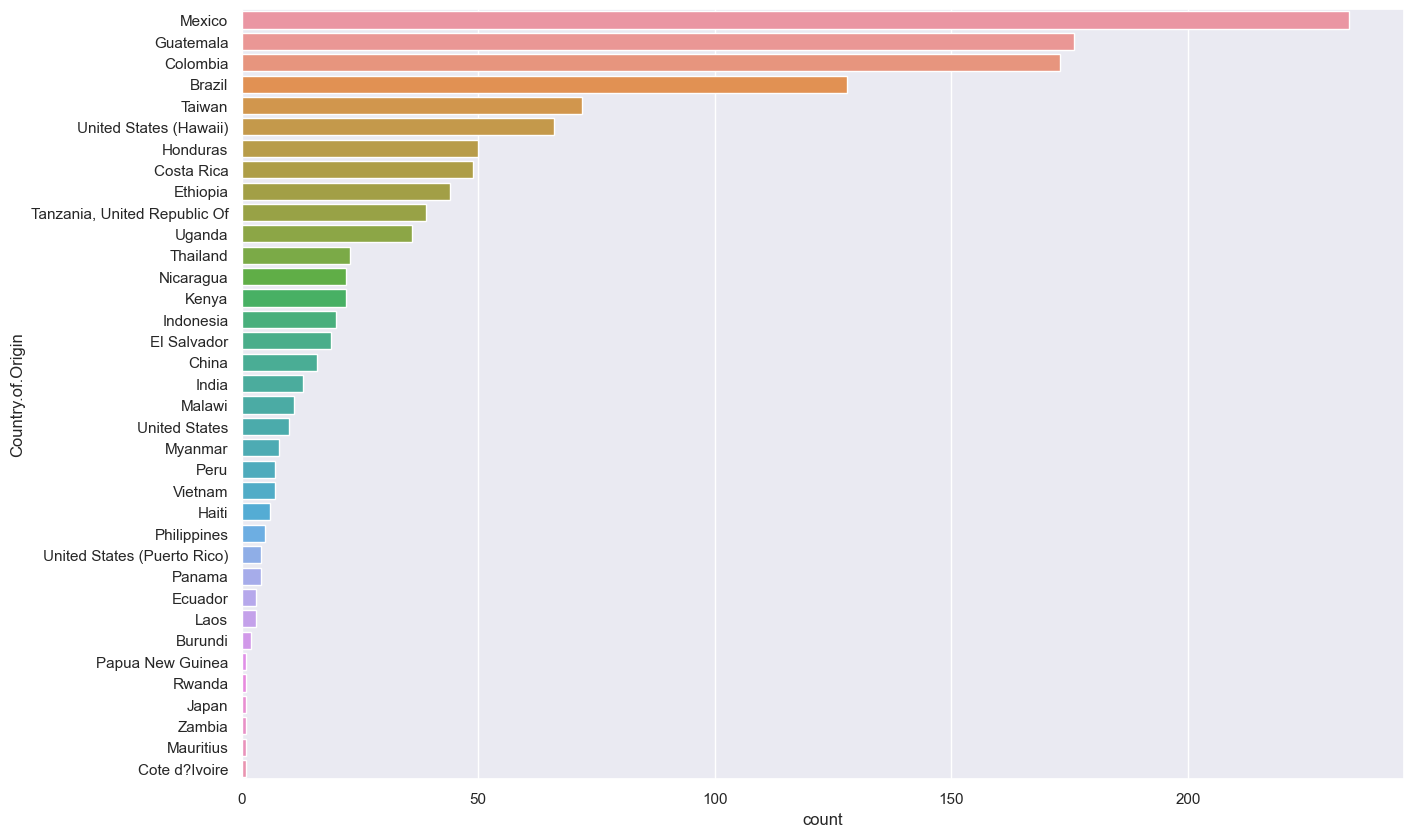

In [71]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(data=df, y="Country.of.Origin", order= df["Country.of.Origin"].value_counts().index, ax=ax)
plt.show()

Los principales países productores de café presentes en el dataset son centroamericanos, con algunos africanos en posiciones centrales y los asiáticos con muy poca representación.

<h4 style="text-align: center;"><ins>2 - Especie</ins></h4>

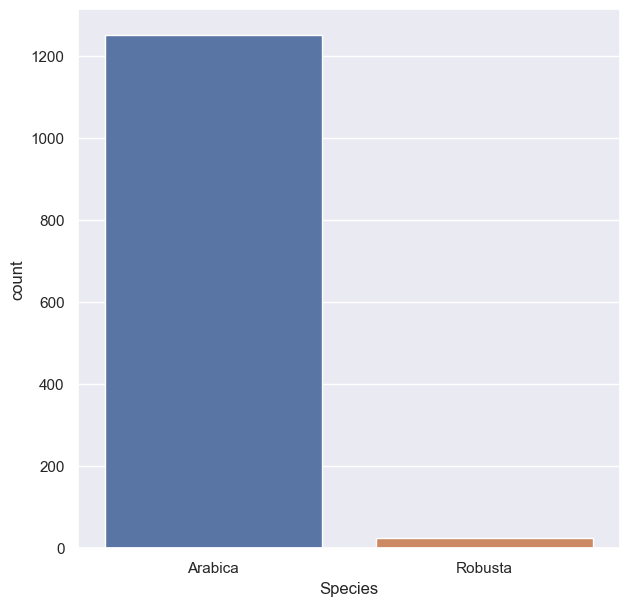

In [72]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.countplot(data=df, x="Species", order= df["Species"].value_counts().index, ax=ax)
plt.show()

El dataset está claramente poblado por más cantidad de registros de la especie "Arabica" que de la especie "Robusta".

Esto debe ser tenido en cuenta en el momento de la realización de predicciones, pues un desequilibrio tan grande afectará negativamente y ha de ser evitado.

<h4 style="text-align: center;"><ins>3 - Variedad</ins></h4>

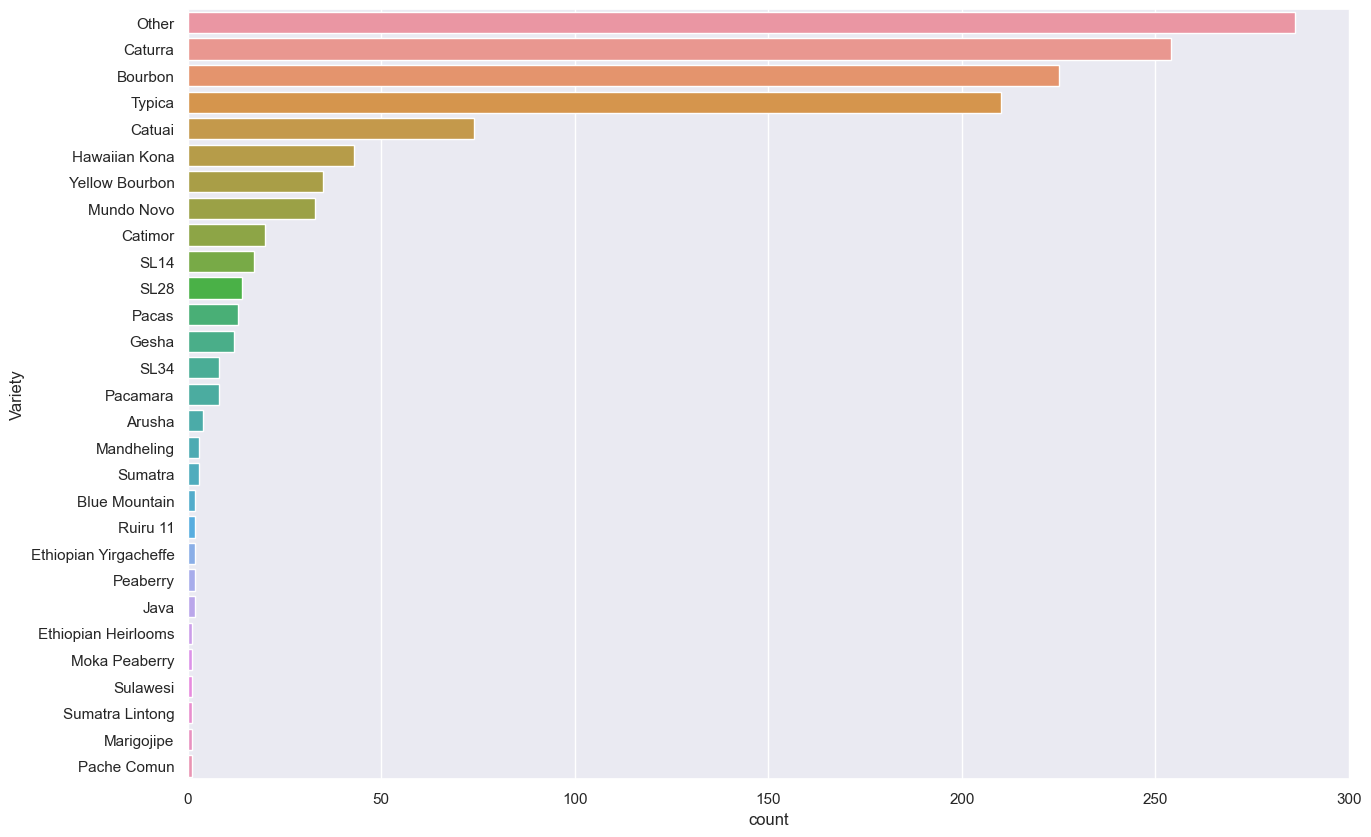

In [73]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(data=df, y="Variety", order= df["Variety"].value_counts().index, ax=ax)
plt.show()

La presencia de tantos registros sin un valor específico de la variedad de café cultivada nos afectará negativamente a la hora de predecir qué variedad es mejor, por lo que lo mejor sería no tener en cuenta este atributo en su momento, aunque vamos a mantenerlo durante el análisis.

<h4 style="text-align: center;"><ins>4 - Altitud</ins></h4>

En vez de graficar los valores de altitud media usaremos los grupos que hemos generado anteriormente a fin de simplificar el análisis.

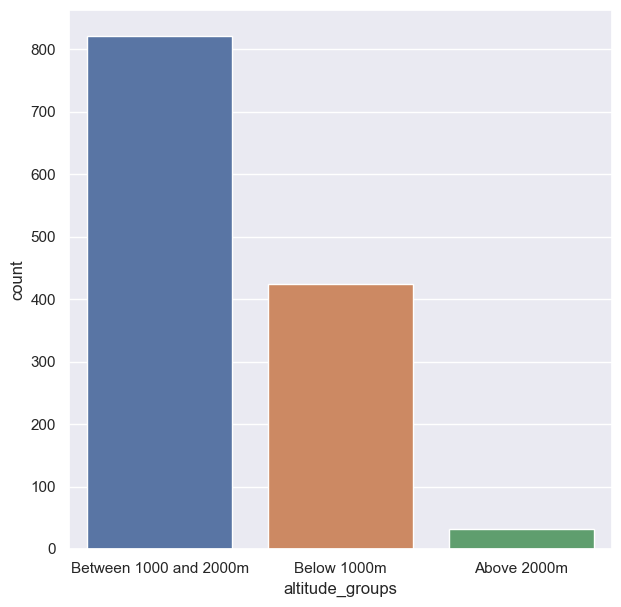

In [74]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.countplot(data=df, x="altitude_groups", order= df["altitude_groups"].value_counts().index, ax=ax)
plt.show()

Puede verse que una inmensa mayoría de las plantaciones se encuentran entre los 1000 y los 2000m de altura.

<h4 style="text-align: center;"><ins>5 - Método de procesado</ins></h4>

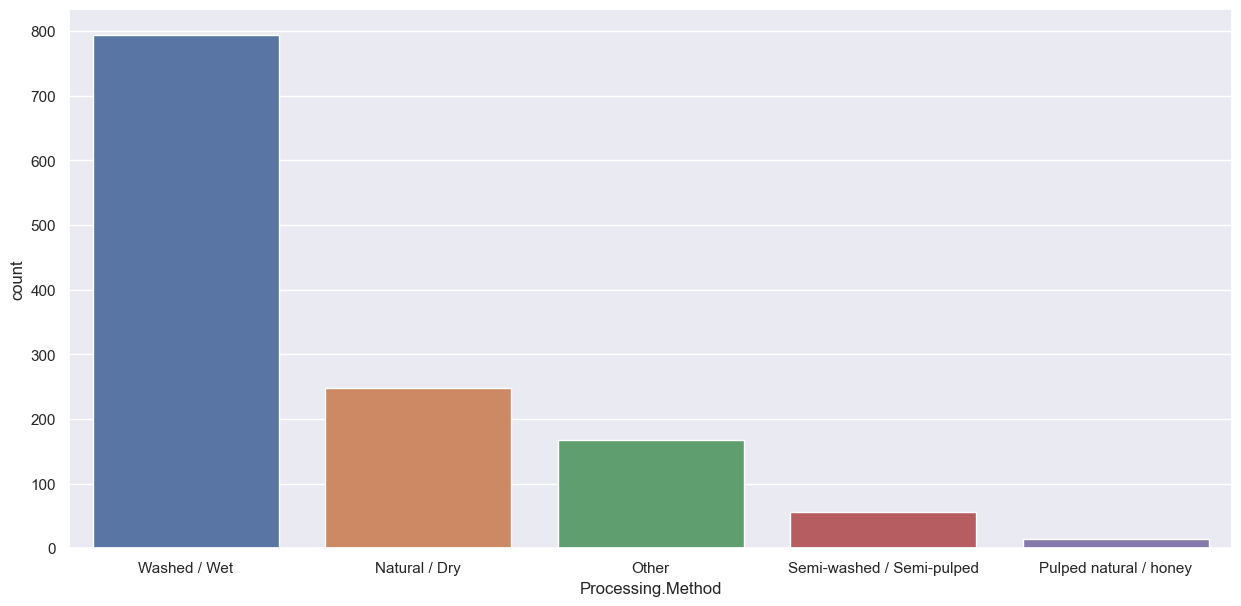

In [75]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.countplot(data=df, x="Processing.Method", order= df["Processing.Method"].value_counts().index, ax=ax)
plt.show()

El método de procesamiento más habitual parece ser el de Lavado, siendo el secado natural el segundo; aunque muy por debajo.

<h4 style="text-align: center;"><ins>6 - Color</ins></h4>

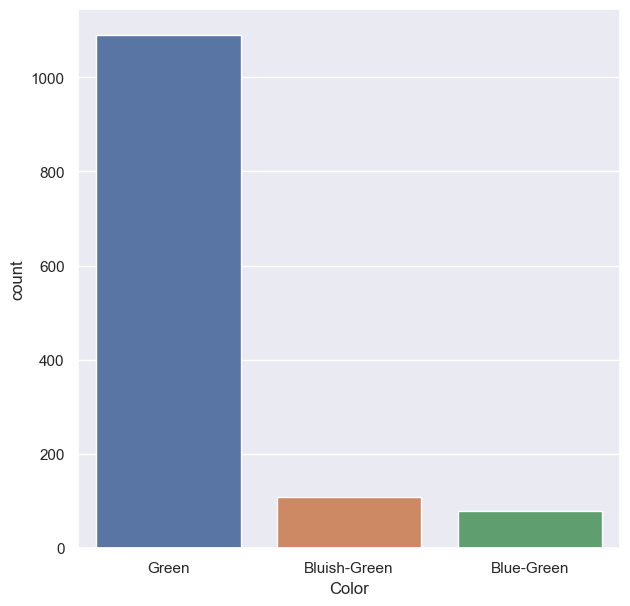

In [76]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.countplot(data=df, x="Color", order= df["Color"].value_counts().index, ax=ax)
plt.show()

Como era esperado, la mayor parte de las semillas de café presentan una coloración verde.

<h4 style="text-align: center;"><ins>7 - Quakers</ins></h4>

En vez de analizar la variable que lista todas las posibles ocurrencias, lo haremos con la versión agrupada.

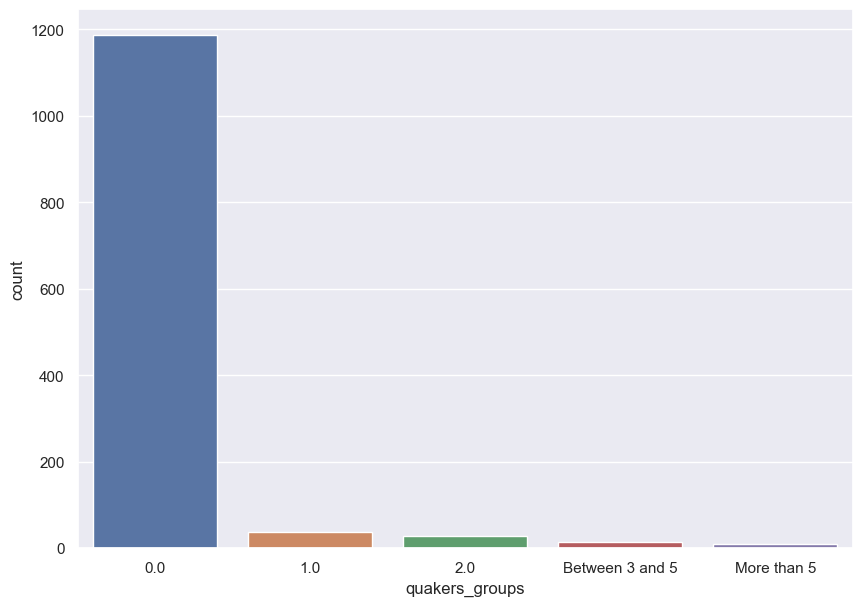

In [77]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.countplot(data=df, x="quakers_groups", order= df["quakers_groups"].value_counts().index, ax=ax)
plt.show()

Prácticamente todos los sacos de café estaban carentes de semillas inmaduras y no tostadas

<h4 style="text-align: center;"><ins>8 - Año de cosecha</ins></h4>

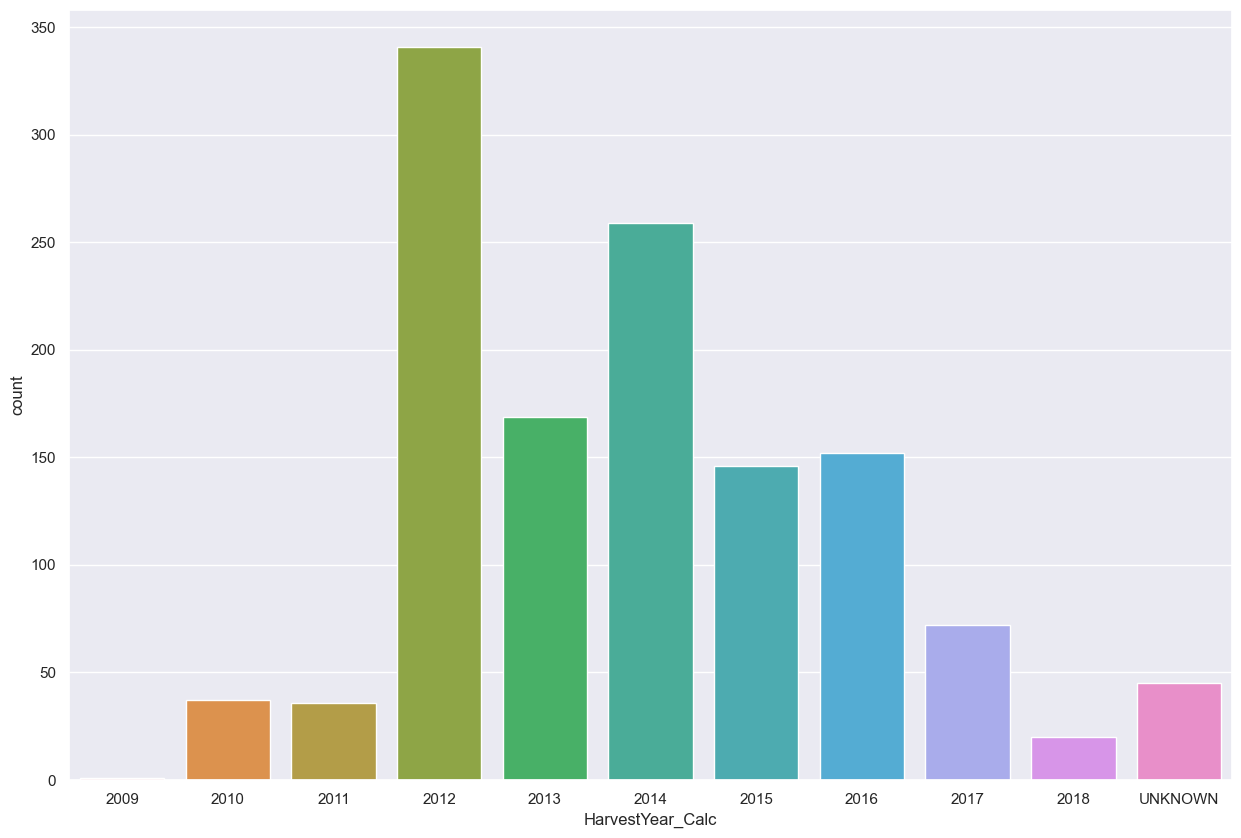

In [78]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(data=df.sort_values(by=["HarvestYear_Calc"]), x="HarvestYear_Calc", ax=ax)
plt.show()

Casi el total de las semillas corresponden a cosechas entre el 2012 y el 2016, con un pequeño grupo del que desconocemos la fecha.

<h4 style="text-align: center;"><ins>9 - Variety</ins></h4>

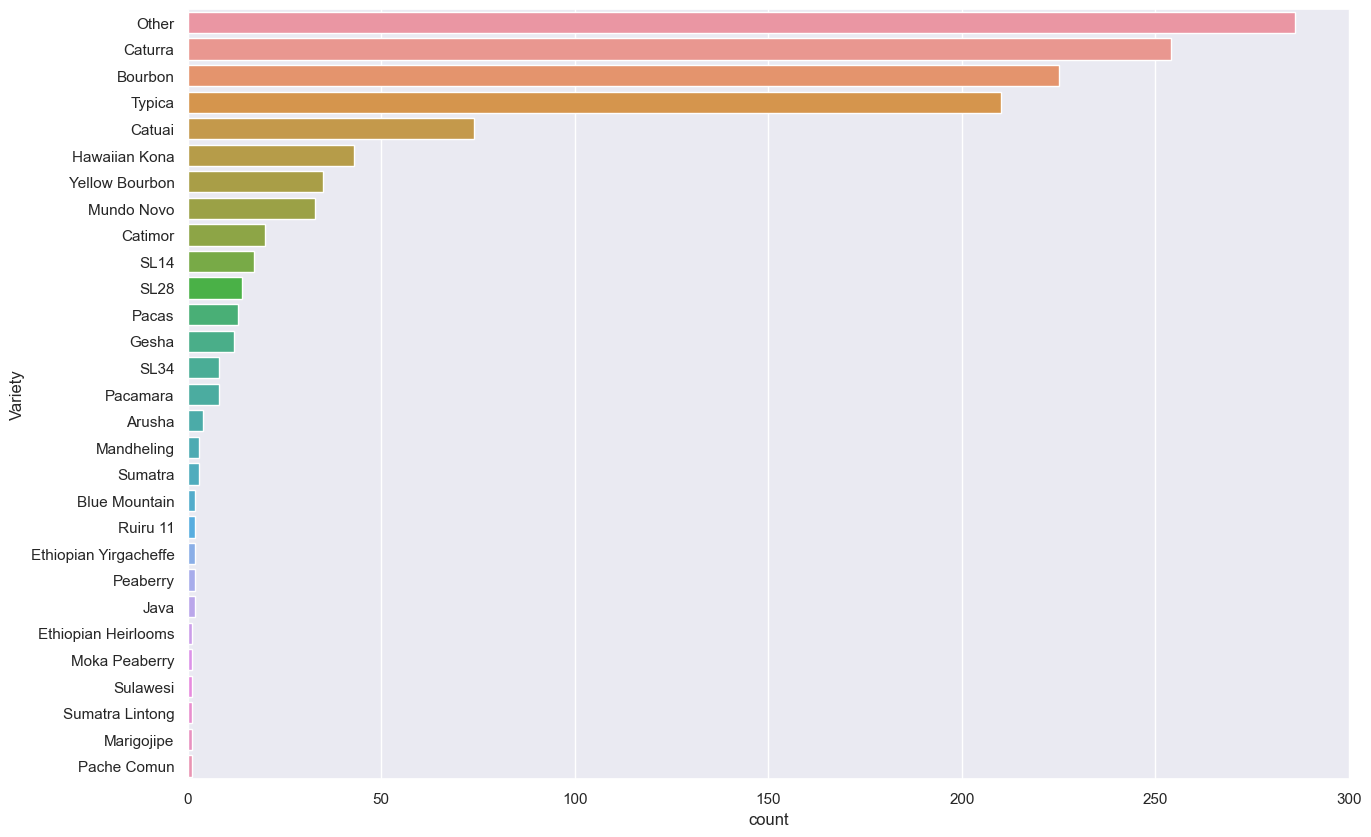

In [79]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(data=df, y="Variety", order= df["Variety"].value_counts().index, ax=ax)
plt.show()

Tenemos demasiados registros para los que no conocemos la variedad. Eso puede ser un problema a la hora de predecir la calidad, por lo que no deberíamos tener en cuenta esos registros o buscar la forma de averiguarlo.

<h4 style="text-align: center;"><ins>10 - Aroma</ins></h4>

<Axes: xlabel='Aroma'>

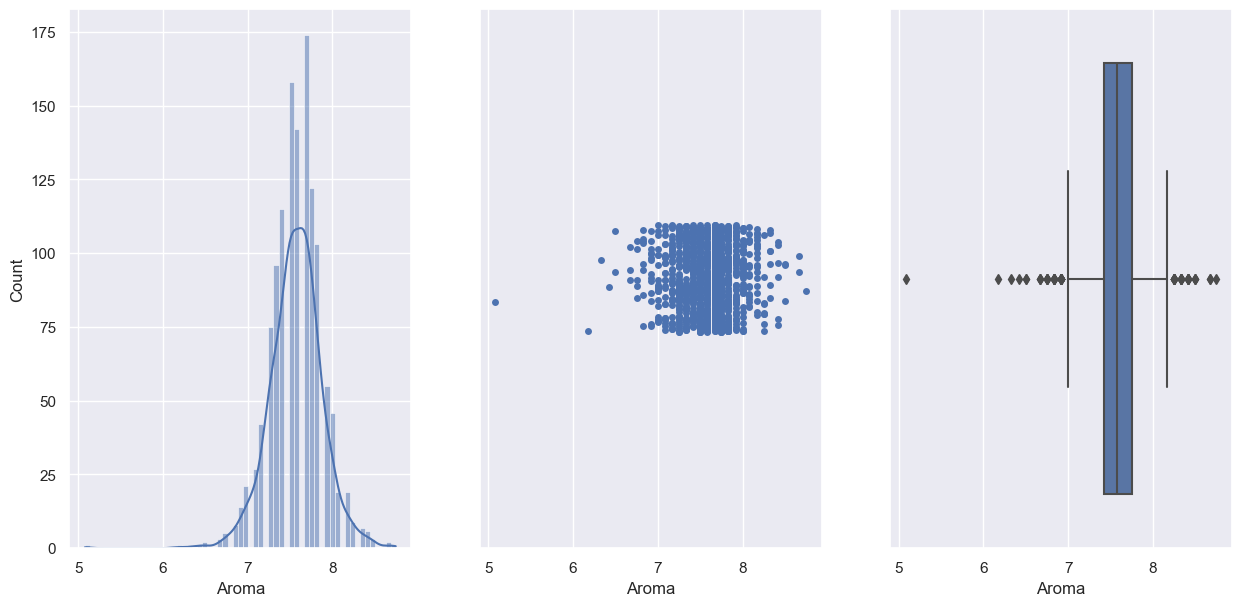

In [80]:
fig, axs = plt.subplots(figsize=(15, 7), ncols=3)
sns.histplot(data=df, x="Aroma", kde=True, ax=axs[0])
sns.stripplot(x=df["Aroma"], ax=axs[1])
sns.boxplot(data=df, x="Aroma", ax=axs[2])


Las gráficas de distribución y dispersión parecen indicar que la mayor parte de los valores para el aroma se encuentran en una puntuación entre 7 y 8, con algunos valores residuales por debajo de 6.5

De acuerdo al diagrama de caja, encontramos un valor potencialmente fuera de rango con una puntuación cercana al 5, aunque la consideramos válida.

<h4 style="text-align: center;"><ins>11 - Sabor</ins></h4>

<Axes: xlabel='Flavor'>

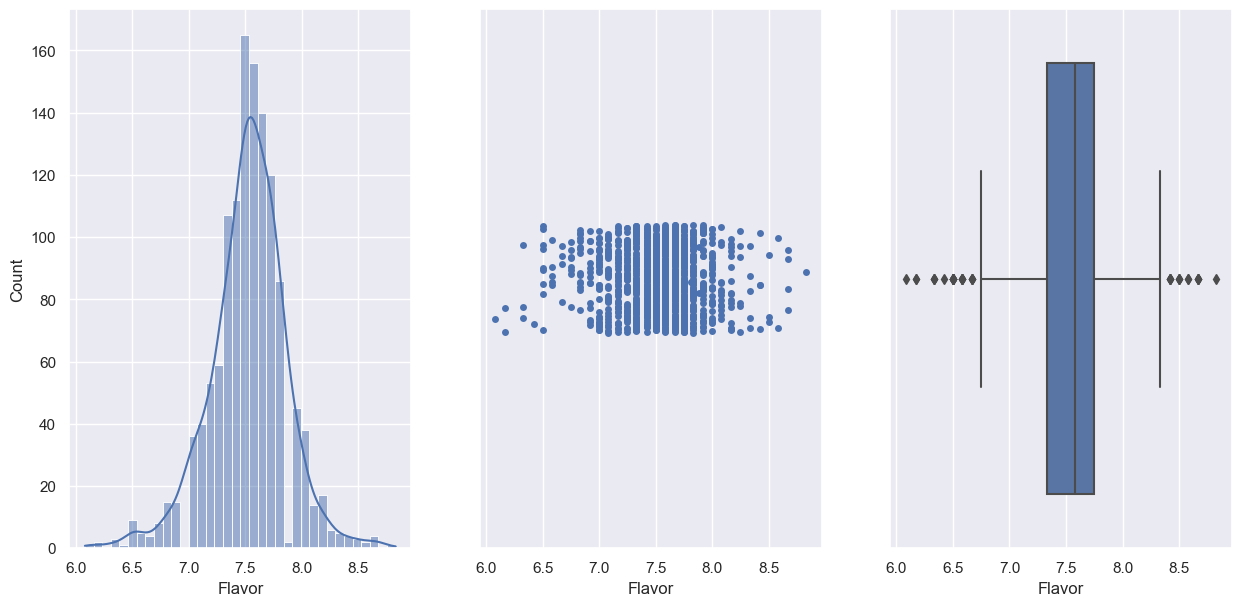

In [81]:
fig, axs = plt.subplots(figsize=(15, 7), ncols=3)
sns.histplot(data=df, x="Flavor", kde=True, ax=axs[0])
sns.stripplot(x=df["Flavor"], ax=axs[1])
sns.boxplot(data=df, x="Flavor", ax=axs[2])

Las gráficas de distribución y dispersión muestran que los valores de la variable Flavor se encuentran en la horquilla entre el 6 y el 8, con escasos valores potencialmente fuera de rango pero válidos dentro de la puntuación.

La mediana está ligeramente desplazada hacia el lado superior del rango intercuartílico.

<h4 style="text-align: center;"><ins>12 - Regusto</ins></h4>

<Axes: xlabel='Aftertaste'>

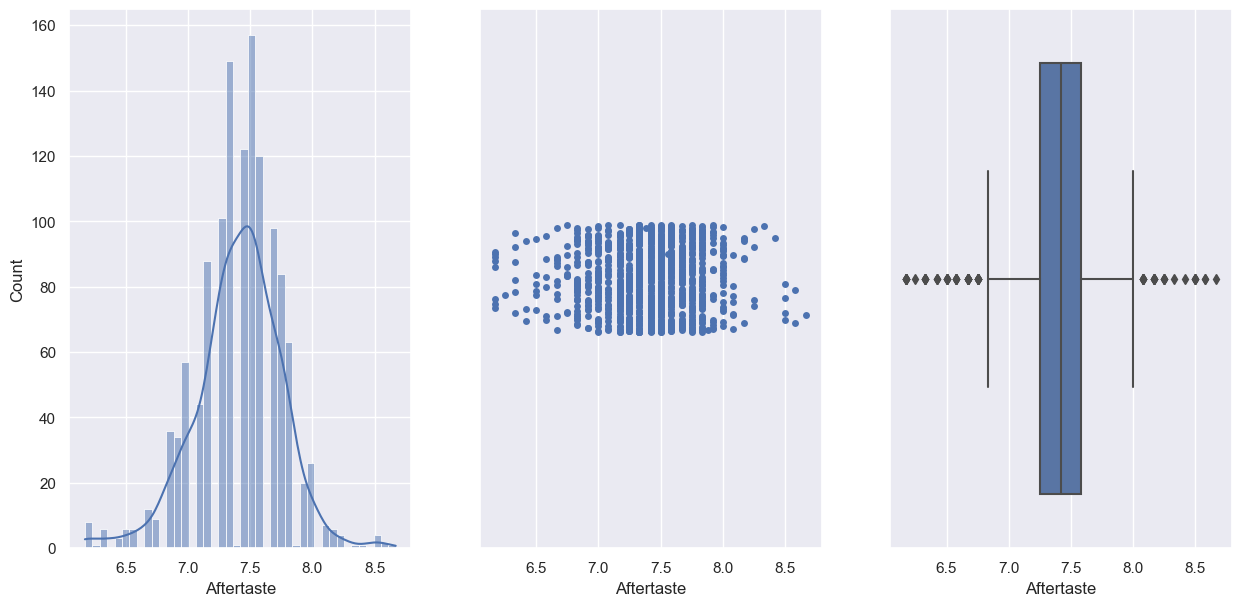

In [82]:
fig, axs = plt.subplots(figsize=(15, 7), ncols=3)
sns.histplot(data=df, x="Aftertaste", kde=True, ax=axs[0])
sns.stripplot(x=df["Aftertaste"], ax=axs[1])
sns.boxplot(data=df, x="Aftertaste", ax=axs[2])

Las gráficas de distribución y dispersión muestran que los valores de la variable Aftertaste también se encuentran en la horquilla entre el 6 y el 8, con algunos casos valores potencialmente fuera de rango pero válidos dentro de la puntuación.

La mediana está muy centrada en el rango intercuartílico, lo que refuerza la idea de que sigue una distribución próxima a la normal.

<h4 style="text-align: center;"><ins>13 - Cuerpo</ins></h4>

<Axes: xlabel='Body'>

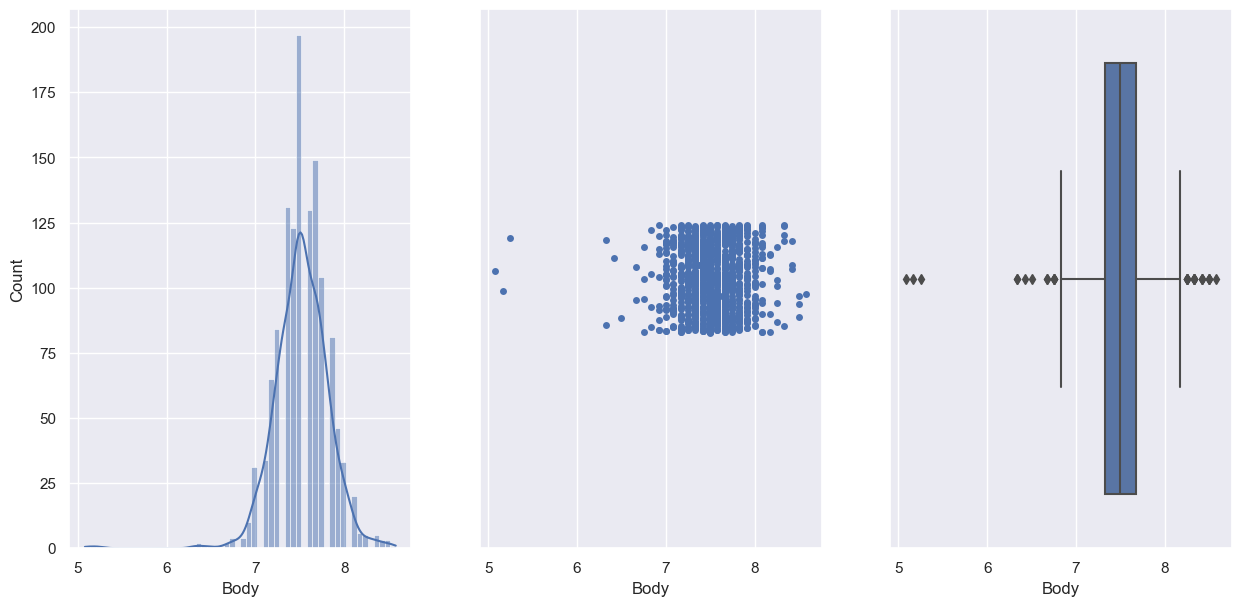

In [83]:
fig, axs = plt.subplots(figsize=(15, 7), ncols=3)
sns.histplot(data=df, x="Body", kde=True, ax=axs[0])
sns.stripplot(x=df["Body"], ax=axs[1])
sns.boxplot(data=df, x="Body", ax=axs[2])

De acuerdo a las gráficas de distribución y dispersión, los valores de la variable Body también se encuentran en la horquilla entre el 7 y el 8, con algunos potencialmente fuera de rango pero válidos dentro de la puntuación.

La mediana está casi centrada en el rango intercuartílico, lo que refuerza la idea de que sigue una distribución próxima a la normal.

<h4 style="text-align: center;"><ins>14 - Dulzor</ins></h4>

<Axes: xlabel='Sweetness'>

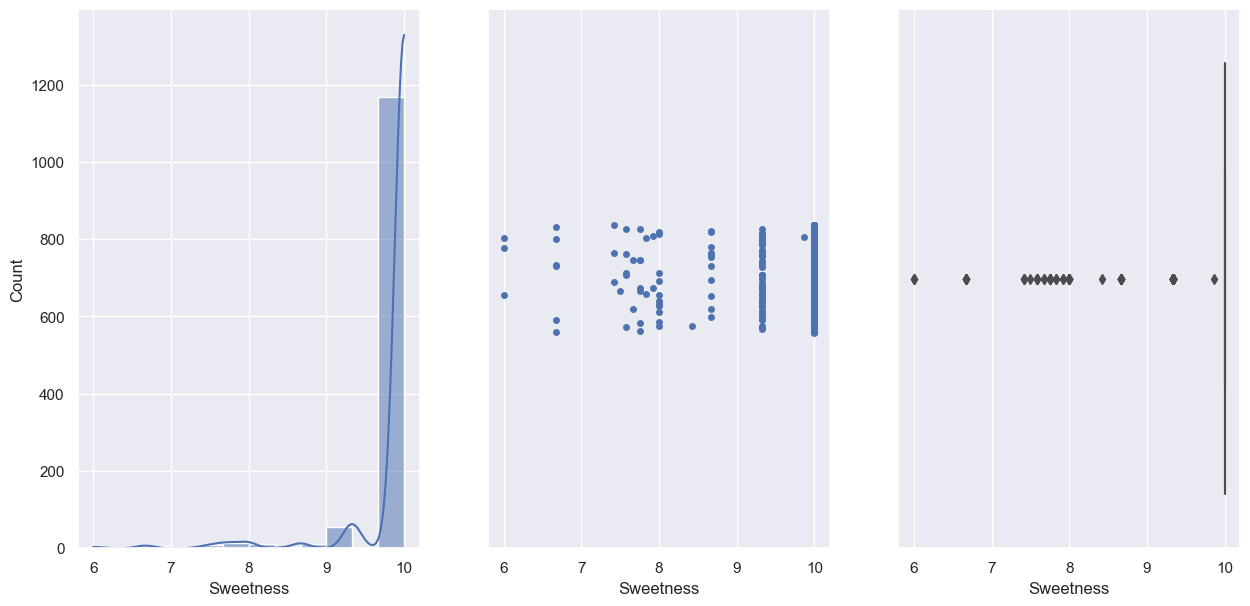

In [84]:
fig, axs = plt.subplots(figsize=(15, 7), ncols=3)
sns.histplot(data=df, x="Sweetness", kde=True, ax=axs[0])
sns.stripplot(x=df["Sweetness"], ax=axs[1])
sns.boxplot(data=df, x="Sweetness", ax=axs[2])

La distribución de la variable está prácticamente centralizada en el valor 10, con un pequeño grupo en el valor 9 y el resto en 8 o inferior.

La distribución no se aproxima a la normal.

Esta característica puede que no sea de mucha ayuda en la predicción, pues la práctica totalidad de los valores son el máximo.

<h4 style="text-align: center;"><ins>15 - Acidez</ins></h4>

<Axes: xlabel='Acidity'>

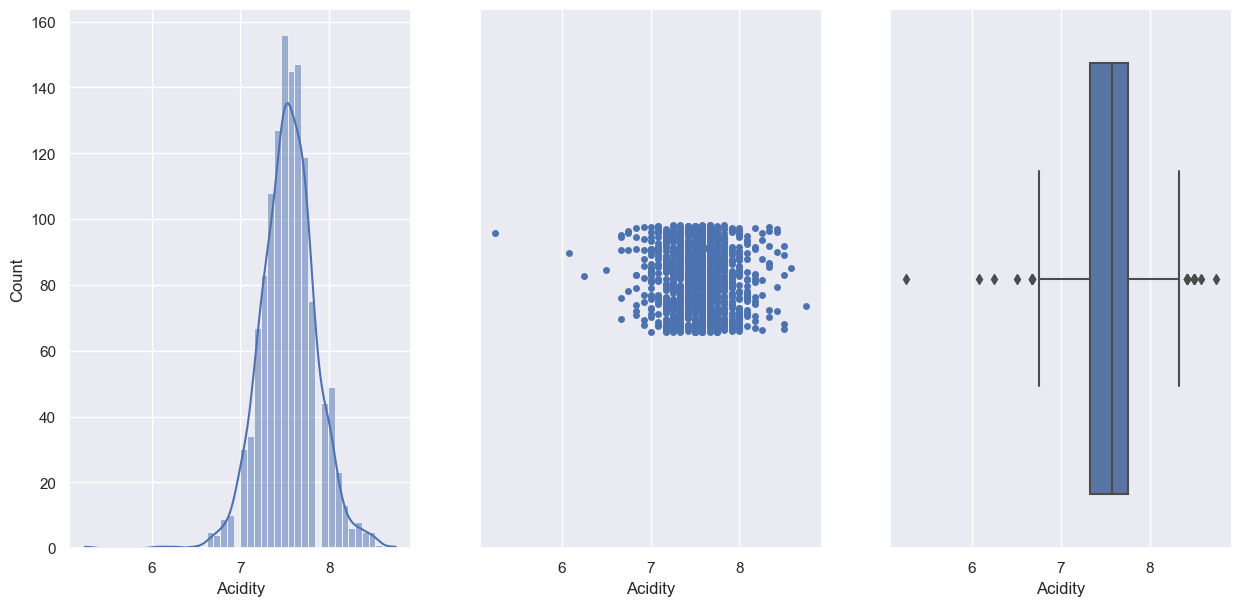

In [85]:
fig, axs = plt.subplots(figsize=(15, 7), ncols=3)
sns.histplot(data=df, x="Acidity", kde=True, ax=axs[0])
sns.stripplot(x=df["Acidity"], ax=axs[1])
sns.boxplot(data=df, x="Acidity", ax=axs[2])

De acuerdo a las gráficas de dispersión y distribución podemos inferir que los datos están concentrados en la horquilla de valores entre el 7 y el 8, con algunos valores fuera de ese rango pero válidos dentro de lo esperado.

La distribución, dada la gráfica y la posición de la mediana en el diagrama de caja, se aproxima a la normal.

<h4 style="text-align: center;"><ins>16 - Equilibrio</ins></h4>

<Axes: xlabel='Balance'>

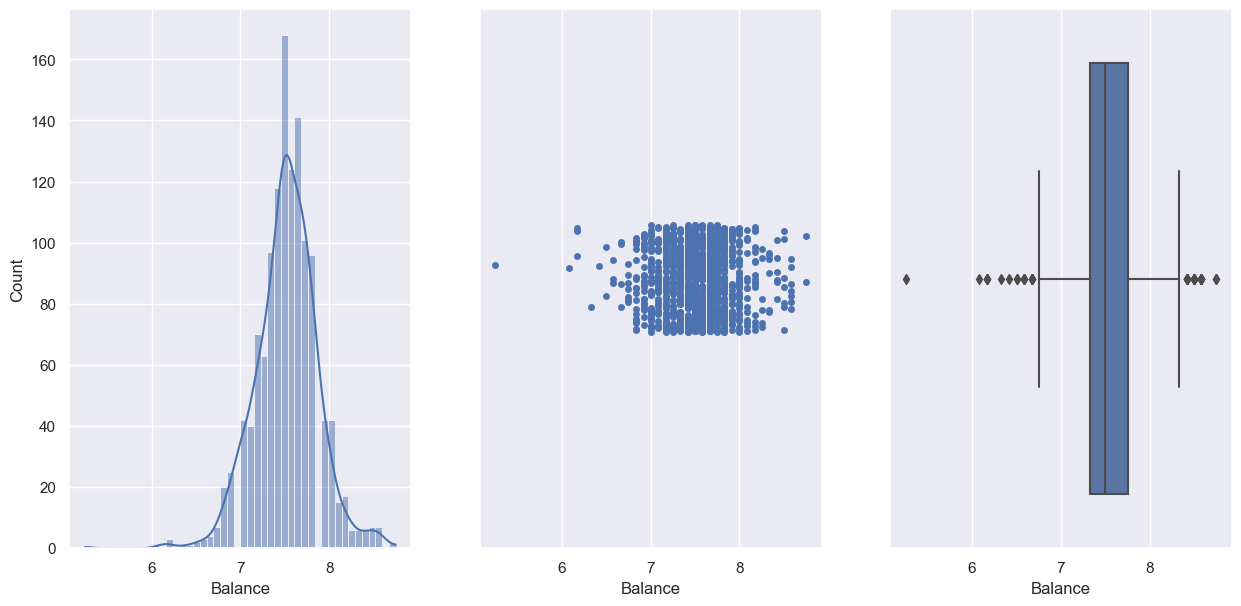

In [86]:
fig, axs = plt.subplots(figsize=(15, 7), ncols=3)
sns.histplot(data=df, x="Balance", kde=True, ax=axs[0])
sns.stripplot(x=df["Balance"], ax=axs[1])
sns.boxplot(data=df, x="Balance", ax=axs[2])

Examinando las gráficas se observa que los valores de la variable Balance se distribuyen alrededor de las puntuaciones 7 y 8, con algunos valores fuera de ese rango, pero perfectamente válidos.

La distribución, de acuerdo a la gráfica y a la posición de la mediana en el diagrama de caja, aunque no sigue una normal sí que se aproxima a ella.

<h4 style="text-align: center;"><ins>17 - Uniformidad</ins></h4>

<Axes: xlabel='Uniformity'>

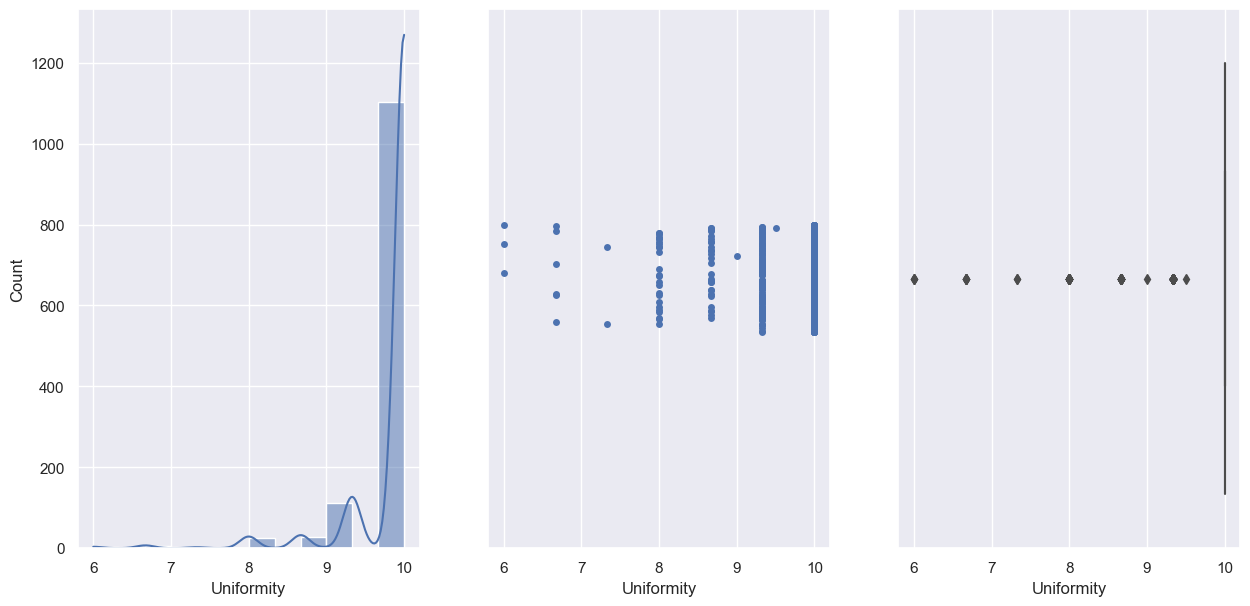

In [87]:
fig, axs = plt.subplots(figsize=(15, 7), ncols=3)
sns.histplot(data=df, x="Uniformity", kde=True, ax=axs[0])
sns.stripplot(x=df["Uniformity"], ax=axs[1])
sns.boxplot(data=df, x="Uniformity", ax=axs[2])

Como ya esperábamos tras el análisis de los datos de la variable Uniformity la distribución está entre la puntuación 9 y 10, muy alejada de una distribución normal.

Al igual que con la variable Sweetness, es posible que esta variable no nos sea de mucha ayuda a la hora de realizar la predicción, dado que la mayor parte de sus valores están en el máximo.

<h4 style="text-align: center;"><ins>18 - Clean Cup</ins></h4>

<Axes: xlabel='Clean.Cup'>

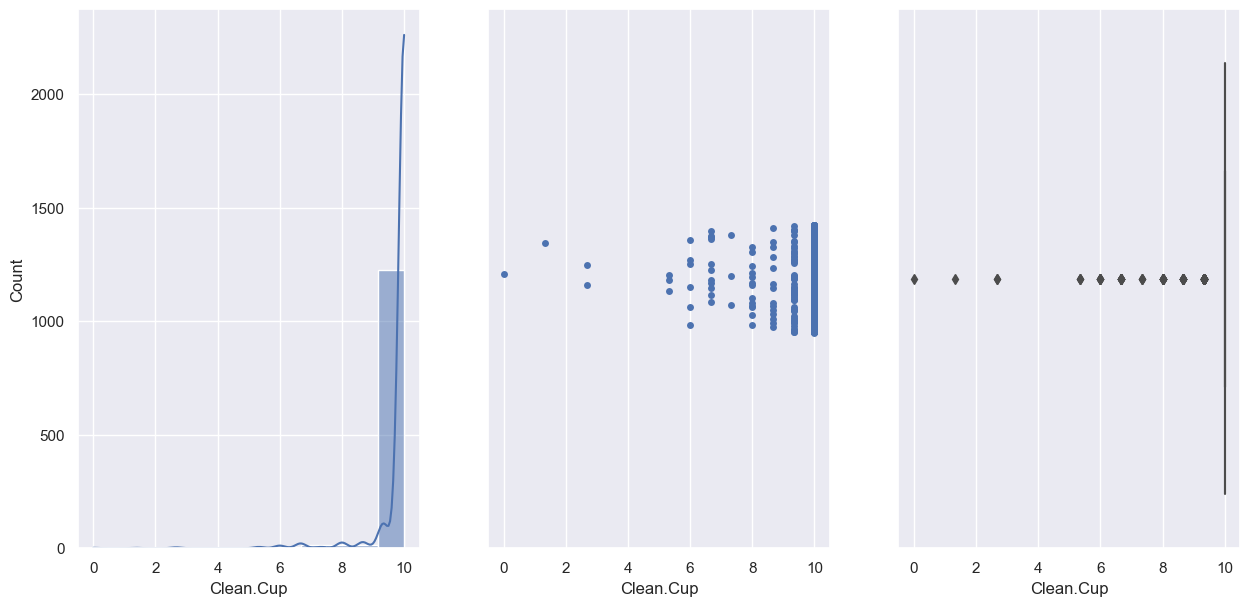

In [90]:
fig, axs = plt.subplots(figsize=(15, 7), ncols=3)
sns.histplot(data=df, x="Clean.Cup", kde=True, ax=axs[0])
sns.stripplot(x=df["Clean.Cup"], ax=axs[1])
sns.boxplot(data=df, x="Clean.Cup", ax=axs[2])

El análisis de los datos de la variable Clean Cup ya nos apuntaba que la distribución iba a estar entre la puntuación 9 y 10, muy alejada de una distribución normal. Además, tenemos la presencia de valores fuera de rango que no podemos tratar pues pueden ser correctos dada la característica.

Al igual que antes, es posible que esta variable no nos sea de mucha ayuda a la hora de realizar la predicción, dado que la mayor parte de sus valores están en el máximo.

<h4 style="text-align: center;"><ins>19 - Humedad</ins></h4>

<Axes: xlabel='Moisture'>

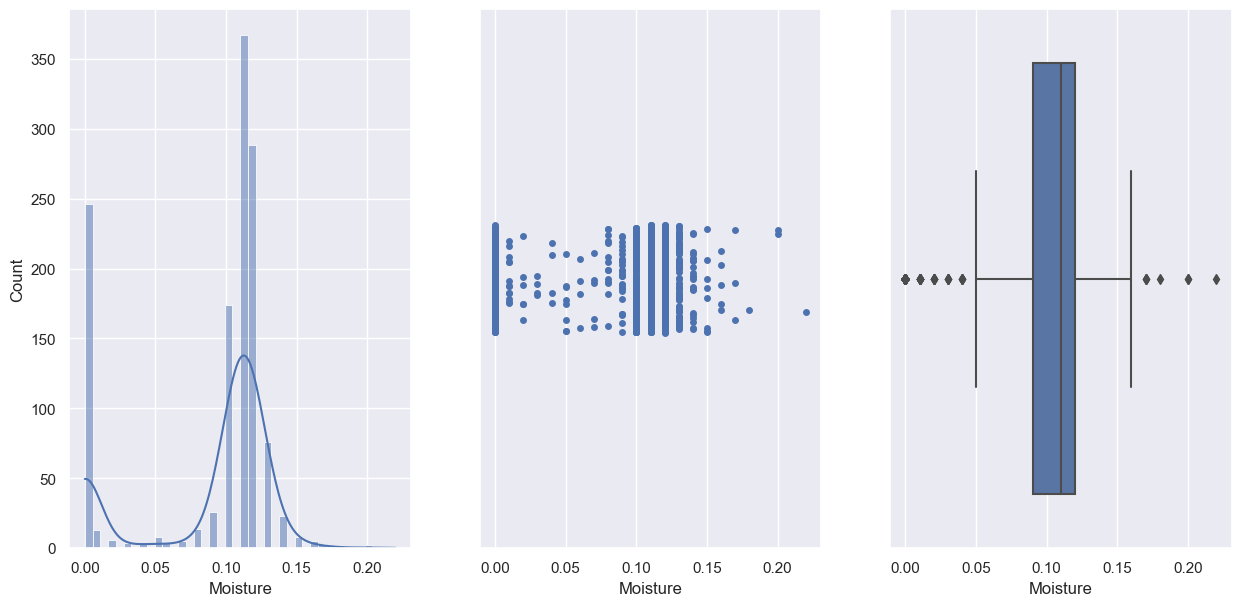

In [96]:
fig, axs = plt.subplots(figsize=(15, 7), ncols=3)
sns.histplot(data=df, x="Moisture", kde=True, ax=axs[0])
sns.stripplot(x=df["Moisture"], ax=axs[1])
sns.boxplot(data=df, x="Moisture", ax=axs[2])

De acuerdo a lo que podemos interpretar de las gráficas de distribución y dispersión, la mayor parte de los datos se encuentran entre los valores 0,10 y 0,15 de humedad, con un gran número de ellos también con el valor 0,00.

Seguimos pensando que el valor 0,00 de humedad es algo poco probable siendo semillas de café, pero no podemos realizar ningún cambio ni imputación.

<h4 style="text-align: center;"><ins>20 - Defectos Tipo 1</ins></h4>

Dado que en el análisis de los datos decidimos que era mejor realizar agrupamientos, este análisis univariante lo realizaremos sobre esos agrupamientos para una mayor claridad en el análisis.

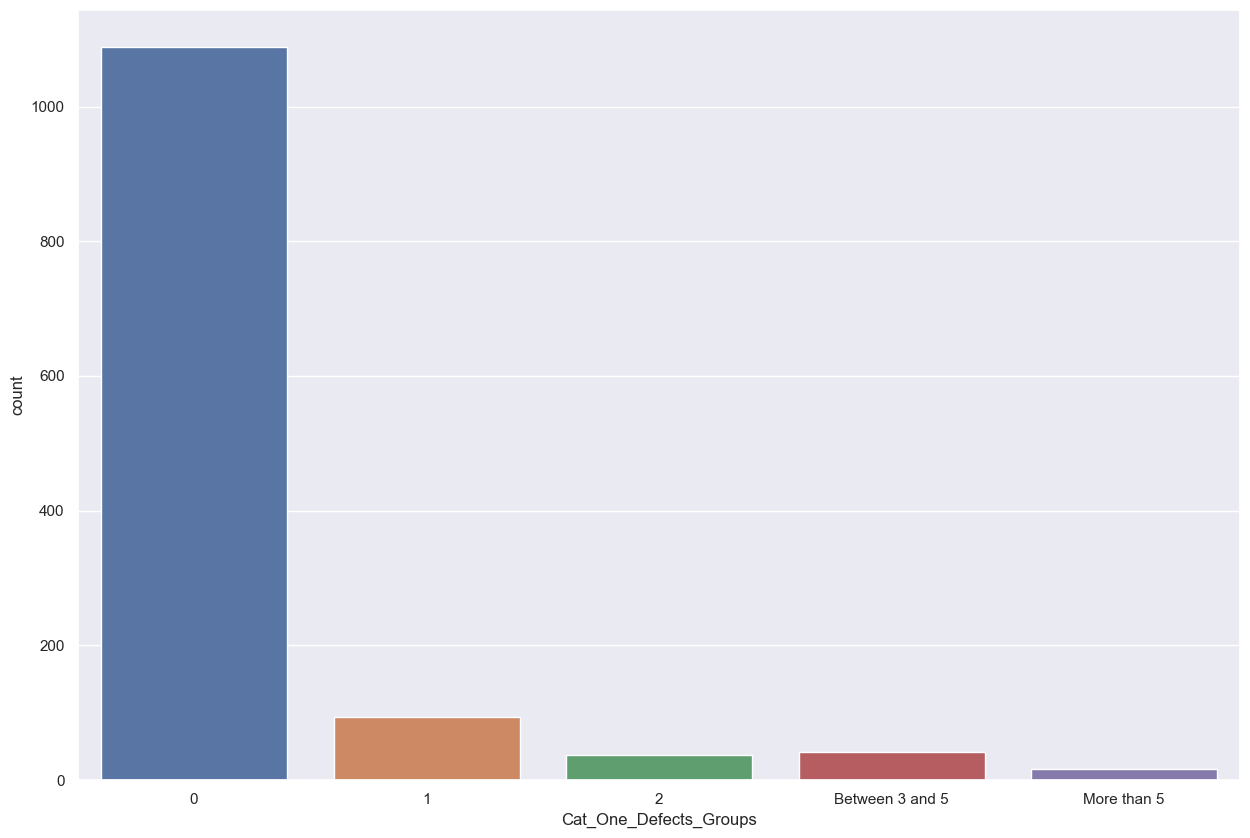

In [104]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(data=df, x="Cat_One_Defects_Groups", ax=ax)
plt.show()

Prácticamente todos los registros tienen un valor 0 para la variable de Defectos Tipo 1.

<h4 style="text-align: center;"><ins>21 - Defectos Tipo 2</ins></h4>

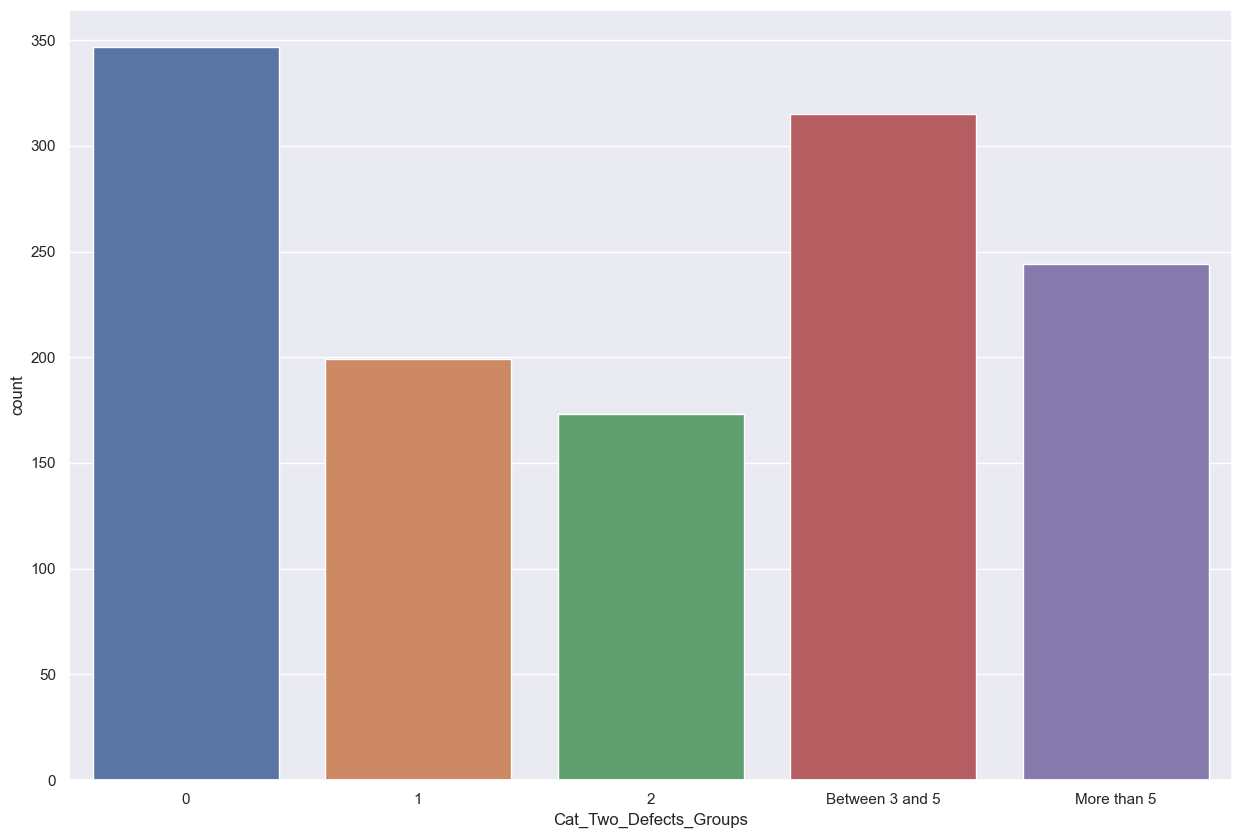

In [110]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(data=df, x="Cat_Two_Defects_Groups", ax=ax)
plt.show()

Podemos ver que para esta característica hay bastantes registros con un valor de 0 defectos, siendo el siguiente en cantidad los que presentan entre 3 y 5 defectos.

<h4 style="text-align: center;"><ins>22 - Total de puntos</ins></h4>

<Axes: xlabel='Total.Cup.Points'>

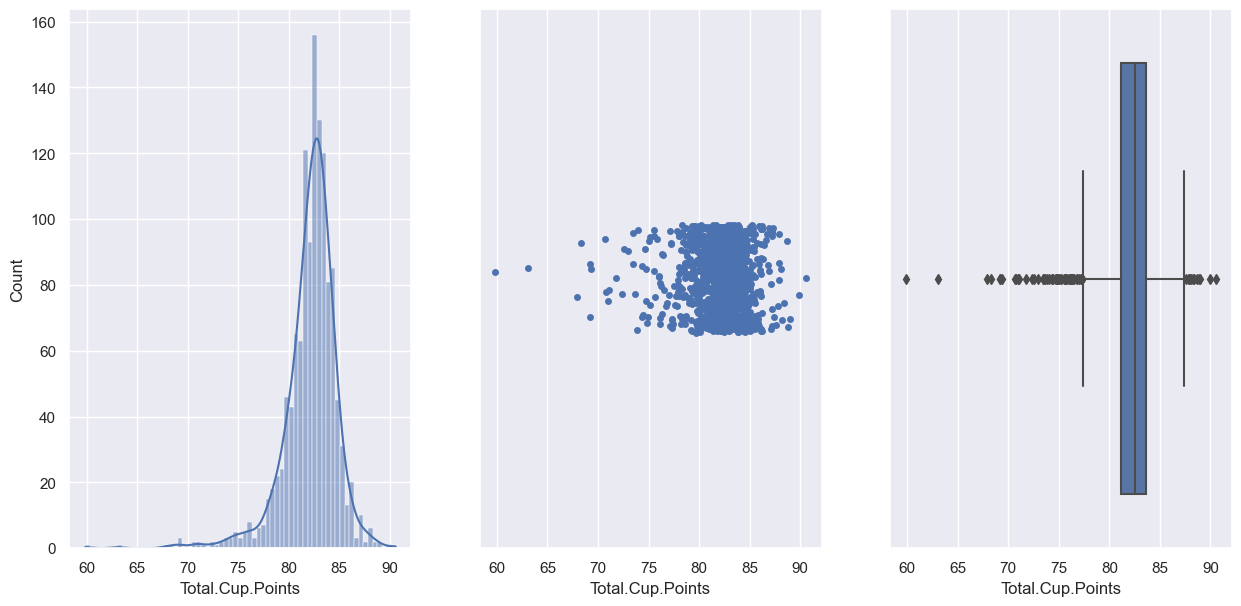

In [113]:
fig, axs = plt.subplots(figsize=(15, 7), ncols=3)
sns.histplot(data=df, x="Total.Cup.Points", kde=True, ax=axs[0])
sns.stripplot(x=df["Total.Cup.Points"], ax=axs[1])
sns.boxplot(data=df, x="Total.Cup.Points", ax=axs[2])